In [2]:
import math
import pandas as pd
import copy
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from prettytable import MARKDOWN
from numpy.random import normal
import numpy as np
import matplotlib

In [3]:
file = "geolife_sample.txt.gz"

In [4]:
df = pd.read_csv(file, sep=',')

In [5]:
df.head(5)

,lat,lng,datetime,uid
0,39.984094,116.319236,2008-10-23 05:53:05,1
1,39.984198,116.319322,2008-10-23 05:53:06,1
2,39.984224,116.319402,2008-10-23 05:53:11,1
3,39.984211,116.319389,2008-10-23 05:53:16,1
4,39.984217,116.319422,2008-10-23 05:53:21,1


In [6]:
df.sort_values(by=["uid"], inplace=True)

In [7]:
# Here, we get the unique trajectories
unique_uids = df.drop_duplicates(["uid"])
unique_uids = unique_uids["uid"].to_list()

In [8]:
class Point:
    R = 6371 # Radius of the earth
    def __init__(self, latitude, longitude, t):
        self.latitude = latitude
        self.longitude = longitude
        self.t = t
        
    def __str__(self):
        return "Point({},{},{})".format(self.latitude, self.longitude, self.t)
    
    def getDistance(self, point2):
        delta_lambda = math.radians(point2.latitude - self.latitude)
        delta_phi = math.radians(point2.longitude - self.longitude)
        a = math.sin(delta_lambda / 2) * math.sin(delta_lambda / 2) + math.cos(math.radians(self.latitude)) \
        * math.cos(math.radians(point2.latitude)) * math.sin(delta_phi / 2) * math.sin(delta_phi / 2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        distance = Point.R * c
        return distance

In [9]:
class Trajectory:
    def __init__(self, points = []):
        self.points = points
        
    def addNoise(self, mu, sigma):
        return Trajectory([Point(i.latitude + normal(mu, sigma), i.longitude + normal(mu, sigma), i.t) for i in self.points])

In [10]:
# Then, we split the trajectories
points = []
trajectories = []
for i in range(len(unique_uids)):
#for i in range(1):
    tmp_df = df.loc[df["uid"]==unique_uids[i]]
    len(tmp_df)
    for j in range(len(tmp_df)):
        points.append(Point(tmp_df.iloc[j][0], tmp_df.iloc[j][1], tmp_df.iloc[j][2]))
    trajectories.append(copy.deepcopy(points))
    points.clear()
    

In [11]:
len(trajectories)

2

In [50]:
P = Trajectory(trajectories[0])

In [51]:
Q = P.addNoise(0, 0.0005)
#Q = Trajectory(trajectories[1])

In [52]:
len(P.points)

108607

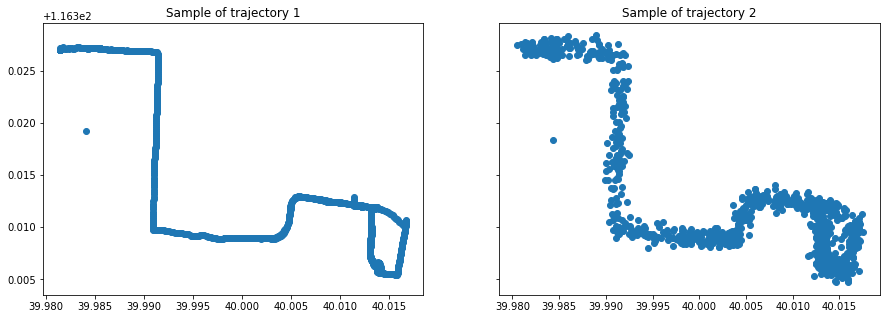

In [53]:
start = 0
limit = 1000
sampleTraj1 = [[i.latitude for i in P.points[start:limit]], [i.longitude for i in P.points[start:limit]]]
sampleTraj2 = [[i.latitude for i in Q.points[start:limit]], [i.longitude for i in Q.points[start:limit]]]
traj1 = pd.DataFrame(sampleTraj1).transpose()
traj2 = pd.DataFrame(sampleTraj2).transpose()
traj1.columns = traj2.columns = ["latitude", "longitude"]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15, 5))
ax1.scatter(traj1.latitude, traj1.longitude, zorder=1)
ax1.set_title('Sample of trajectory 1')

ax2.scatter(traj2.latitude, traj2.longitude, zorder=1)
ax2.set_title('Sample of trajectory 2')

plt.show()

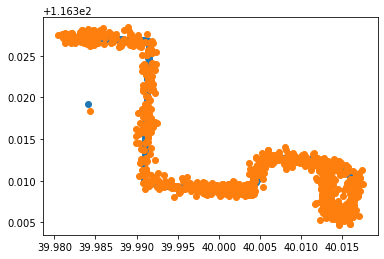

In [54]:
plt.scatter(traj1.latitude, traj1.longitude)
plt.scatter(traj2.latitude, traj2.longitude)
plt.show()

In [55]:
len(traj1)

1000

In [56]:
len(Q.points)

108607

In [57]:
Q.points=Q.points[1:1001]
P.points=P.points[1:1001]

In [58]:
# This code generates the distance matrix in a markdown format
row = []
x = PrettyTable()
x.set_style(MARKDOWN)
x.header = False
for i in Q.points[0:10]:
    for j in P.points[0:10]:
        row.append(round(i.getDistance(j), 2))
    x.add_row(row)
    row = []
print(x.get_html_string())

<table>
    <tbody>
        <tr>
            <td>0.02</td>
            <td>0.04</td>
            <td>0.05</td>
            <td>0.06</td>
            <td>0.07</td>
            <td>0.08</td>
            <td>0.1</td>
            <td>0.1</td>
            <td>0.1</td>
            <td>0.1</td>
        </tr>
        <tr>
            <td>0.11</td>
            <td>0.12</td>
            <td>0.13</td>
            <td>0.13</td>
            <td>0.13</td>
            <td>0.14</td>
            <td>0.15</td>
            <td>0.15</td>
            <td>0.15</td>
            <td>0.14</td>
        </tr>
        <tr>
            <td>0.05</td>
            <td>0.07</td>
            <td>0.08</td>
            <td>0.09</td>
            <td>0.11</td>
            <td>0.12</td>
            <td>0.13</td>
            <td>0.13</td>
            <td>0.13</td>
            <td>0.13</td>
        </tr>
        <tr>
            <td>0.1</td>
            <td>0.09</td>
            <td>0.08</td>
            <td>0.06</td>
       

In [59]:
row = []
matrix = []
for i in Q.points:
    for j in P.points:
        row.append(round(i.getDistance(j), 2))
    matrix.append(row)
    row = []

In [60]:
m = np.array(matrix)
print(m.shape)

(1000, 1000)


In [67]:
def warping_path(D):
    n = D.shape[0] - 1
    m = D.shape[1] - 1
    P = [(n, m)]
    while n > 0 or m > 0:
        if n == 0:
            min_val = (0, m - 1)
        elif m == 0:
            min_val = (n - 1, 0)
        else:
            val = min(D[n-1, m-1], D[n-1, m], D[n, m-1])
            if val == D[n-1, m-1]:
                min_val = (n-1, m-1)
            elif val == D[n-1, m]:
                min_val = (n-1, m)
            else:
                min_val = (n, m-1)
        P.append(min_val)
        (n, m) = min_val
    P.reverse()
    return np.array(P)
        
P = warping_path(np.array(matrix))
print('Indexes of the most optimal warping path P =', P.tolist())

Indexes of the most optimal warping path P = [[0, 0], [1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0], [9, 0], [10, 0], [11, 0], [12, 0], [13, 0], [14, 0], [15, 0], [15, 1], [15, 2], [15, 3], [15, 4], [15, 5], [15, 6], [15, 7], [15, 8], [15, 9], [15, 10], [15, 11], [16, 11], [17, 11], [17, 12], [17, 13], [17, 14], [17, 15], [17, 16], [17, 17], [18, 17], [19, 17], [20, 18], [20, 19], [20, 20], [20, 21], [21, 21], [22, 22], [23, 23], [24, 23], [25, 23], [26, 23], [27, 23], [28, 23], [29, 23], [30, 23], [31, 23], [32, 23], [33, 23], [34, 23], [35, 23], [36, 23], [37, 23], [38, 23], [39, 23], [40, 23], [41, 23], [42, 23], [43, 23], [43, 24], [43, 25], [44, 25], [45, 26], [45, 27], [45, 28], [45, 29], [45, 30], [45, 31], [45, 32], [45, 33], [45, 34], [45, 35], [45, 36], [46, 37], [46, 38], [46, 39], [46, 40], [46, 41], [46, 42], [46, 43], [46, 44], [46, 45], [46, 46], [46, 47], [47, 48], [48, 48], [49, 49], [50, 50], [51, 51], [52, 51], [52, 52], [53, 53], [54, 53], [55, 53],

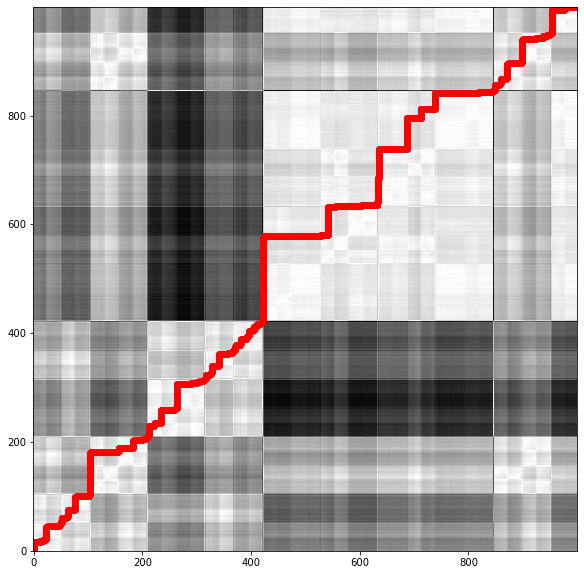

In [81]:
plt.figure(figsize=(25, 10))
plt.imshow(matrix, cmap='gray_r', origin='lower', aspect='equal', vmin=0, vmax=1, interpolation='nearest')
plt.clim([0, np.max(matrix)])
plt.plot(P[:, 1], P[:, 0], marker='o', color='r')
#plt.title("Illustration of the optimal warping path")

In [166]:
#matrix